In [102]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing

In [793]:
data = pd.read_csv("data.csv", index_col=0) # 1 + 1*4 + 1*4*7 + 1*4*7*2
agg_mat_df = pd.read_csv("agg_mat.csv", index_col=0) # matrix of aggregated data with bottom time series``

maximum = np.max(data.values)
data_scaled = (data / maximum).values

# scaler = preprocessing.StandardScaler().fit(data)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler().fit(data)
# data_scaled = scaler.transform(data)

In [879]:
data_scaled

array([[9.72494908e-01, 5.28304927e-01, 2.99701932e-01, ...,
        2.76201765e-04, 4.02794241e-04, 9.20672551e-05],
       [7.51637071e-01, 3.37737217e-01, 2.37947821e-01, ...,
        7.02012820e-04, 7.94080075e-04, 4.48827869e-04],
       [8.37271127e-01, 3.73931157e-01, 2.36866031e-01, ...,
        2.64693358e-04, 1.72626103e-03, 3.88984153e-03],
       ...,
       [7.77082159e-01, 3.54194239e-01, 2.64094921e-01, ...,
        9.78214586e-04, 3.33743800e-04, 5.98437158e-04],
       [7.58841334e-01, 3.56047092e-01, 2.27302545e-01, ...,
        7.82571669e-04, 8.86147331e-04, 8.28605296e-04],
       [8.00340649e-01, 3.66485217e-01, 2.61908324e-01, ...,
        4.25811055e-04, 3.10726986e-04, 1.58816015e-03]])

In [794]:
def calculate_wmape(actual_values, forecasted_values):
    n = len(actual_values)
    num = np.sum(np.abs(actual_values - forecasted_values))
    den = np.sum(np.abs(actual_values))
    wmape = num/den
    return wmape

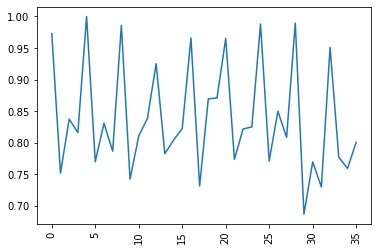

In [885]:
plt.plot(data_scaled[:,0])
plt.xticks(rotation=90);

In [799]:
def make_data(dataset, range_): 
    X_data = []
    y_data = []
    for i in range_:
        X = dataset[i:i+context_window,:].T.flatten()
        X_data.append(X)

        y = dataset[i+context_window:i+context_window+1,:].T.flatten()
        y_data.append(y)

    return torch.tensor(X_data).float(), torch.tensor(y_data).float()

In [800]:
n_series = 89
n_total = data.shape[0]
n_train = 20
context_window = 4

X_train, y_train = make_data(data_scaled, range(n_train))
X_test, y_test = make_data(data_scaled, range(n_train,n_total - context_window))

In [801]:
# weights = torch.tensor([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [802]:
class LinearNet(nn.Module):
    def __init__(self, n_series, context):
        super().__init__()
        # self.input_layer = nn.Linear(n_series * context, 400)
        # self.last_layer = nn.Linear(400, n_series)
        self.last_layer = nn.Linear(n_series * context, n_series)

    def forward(self, x):
        # x = F.relu(self.input_layer(x))
        return self.last_layer(x)

In [804]:
import torch.optim as optim

network = LinearNet(n_series, context_window)
n_epochs = 200

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

losses = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    for i in range(len(X_train)):
        inputs = X_train[i:i+1,:]
        labels = y_train[i:i+1,:]

        optimizer.zero_grad()

        outputs = network(inputs)

        # loss = criterion(outputs * weights, labels * weights)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch % 50 == 0:    
        print("Epoch:", epoch, " Loss: ", np.mean(losses))

Epoch: 0  Loss:  0.01243001497350633
Epoch: 50  Loss:  0.001994718471435001
Epoch: 100  Loss:  0.001088187837689979
Epoch: 150  Loss:  0.0007697265120459513


In [805]:
aggregation_mat = torch.tensor(np.append(np.zeros((agg_mat_df.shape[0], agg_mat_df.shape[0] - agg_mat_df.shape[1])), agg_mat_df, axis=1)).float()

def coherency_loss(network): 
    return torch.norm(aggregation_mat @ network.last_layer.weight - network.last_layer.weight) / torch.norm(network.last_layer.weight)

In [888]:
def visualize(ts, net): 
    with torch.no_grad(): 
        predict = net(X_test).numpy()[:,ts]
        truth = y_test.numpy()[:,ts]

        plt.plot(truth, label = 'truth')
        plt.plot(predict, label = 'prediction')
        plt.legend()

In [860]:
import torch.optim as optim

network_coherent = LinearNet(n_series, context_window)
n_epochs = 500

criterion = nn.MSELoss()
optimizer = optim.Adam(network_coherent.parameters(), lr=0.0001)

alpha = 0.1

losses = []
for epoch in range(n_epochs):  # loop over the dataset multi ple times
    for i in range(len(X_train)):
        inputs = X_train[i:i+1,:]
        labels = y_train[i:i+1,:]

        optimizer.zero_grad()

        outputs = network_coherent(inputs)

        # l1 = criterion(outputs * weights, labels * weights)
        l1 = criterion(outputs, labels) 
        l2 = coherency_loss(network_coherent)

        # print(l1.item(), l2.item())

        loss = l1 + alpha * l2

        loss.backward()
        optimizer.step()

        losses.append(l1.item())
    
    if epoch % 50 == 0:
        print("Epoch:", epoch, " Loss: ", np.mean(losses))

Epoch: 0  Loss:  0.014141319831833244
Epoch: 50  Loss:  0.002603138341053672
Epoch: 100  Loss:  0.0014318609644094365
Epoch: 150  Loss:  0.001024948802875848
Epoch: 200  Loss:  0.000815344479851593
Epoch: 250  Loss:  0.0006855624716874908
Epoch: 300  Loss:  0.0005961741730665792
Epoch: 350  Loss:  0.0005301658494481205
Epoch: 400  Loss:  0.00047894613857932565
Epoch: 450  Loss:  0.0004377919095009675


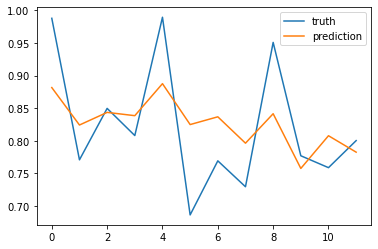

In [899]:
visualize(0, network_coherent)

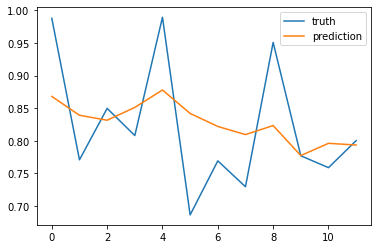

In [900]:
visualize(0, network)

In [894]:
print("WMAPE Baseline:", calculate_wmape(y_test.numpy(), network(X_test).detach().numpy()))
print("WMAPE Coherent:", calculate_wmape(y_test.numpy(), network_coherent(X_test).detach().numpy()))

WMAPE Baseline: 0.14387263
WMAPE Coherent: 0.17822723


In [895]:
all_agg_levels = np.unique([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [896]:
all_agg_levels

array([ 1.,  2., 14., 56.])

Baseline: 0.024273008108139038
Coherent: 0.021863095462322235


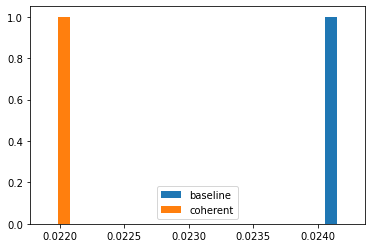

In [898]:
aggregation_level = all_agg_levels[3]
aggregation_amounts = []
errs_baseline = [] 
errs_coherent = []
for ts in range(len(aggregation_mat)):
    agg_level = torch.sum(aggregation_mat[ts,:]).item()
    if agg_level == aggregation_level: 
        err_baseline = torch.norm(network(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)
        err_coherent = torch.norm(network_coherent(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)

        aggregation_amounts.append(agg_level)
        errs_baseline.append(err_baseline)
        errs_coherent.append(err_coherent)

plt.hist([errs_baseline, errs_coherent], label = ['baseline', 'coherent'])
# plt.hist(errs_baseline, label = 'baseline')
# plt.hist(errs_coherent, label = 'coherent', alpha = 0.5)

print("Baseline:", np.mean(errs_baseline))
print("Coherent:", np.mean(errs_coherent))

# plt.scatter(errs_baseline, aggregation_amounts, label = 'baseline')
# plt.scatter(errs_coherent, aggregation_amounts, label = 'coherent')
plt.legend()

In [872]:
coherency_loss(network_coherent)

tensor(0.0006, grad_fn=<DivBackward0>)

In [873]:
coherency_loss(network)

tensor(1.5081, grad_fn=<DivBackward0>)

In [874]:
def coherency_metric(predictions): 
    return torch.norm(predictions - aggregation_mat @ predictions.T) / len(predictions)

In [875]:
coherent_scores = []
for i in range(len(X_test)):
    cur = coherency_metric(network_coherent(X_test[i,:])).item()
    coherent_scores.append(cur)
print("coherent network coherency", np.mean(coherent_scores))

coherent network coherency 1.1803923750145865e-05


In [876]:
baseline_scores = []
for i in range(len(X_test)):
    cur = coherency_metric(network(X_test[i,:])).item()
    baseline_scores.append(cur)
print("baseline network coherency", np.mean(baseline_scores))

baseline network coherency 0.0008986533988111963


In [877]:
np.mean(np.array(baseline_scores) / np.array(coherent_scores))

76.57138240067195